# Scaling collpase cleaned

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from fssa import quality
from tqdm import tqdm
import numpy.ma as ma
import numpy as np
import seaborn as sns
from scipy.optimize import minimize

In [107]:
def load_IDs(L, seeds):
    Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

    ID = -1*np.ones((len(seeds),len(Ws)))
    R2 = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID'] for i in range(len(Ws))])
            R2[seed] = np.array([data[i]['rsquared'] for i in range(len(Ws))])
            
        except:
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    return ID, R2

def x_func(rho, rho_c, l, nu):
    return np.power(l, 1./nu) * (rho-rho_c)

def x_BKT(rho, rho_c, l, alpha):
    return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))

def y_func(y, l, zeta,nu):
    return np.power(l, -zeta/nu) * y

def goal_function(args = [3.,2.2,1.2, 1.4], bounds=[(3.1,3.9),(1.,3.),(1.,3.),(0.,3.)]):
    ''' rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]'''
    rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]
    
    x,y,dy = scaledata(l,rho,a,da,rho_c,nu,zeta, alpha)
    
    if bounds == None:
        pass
    else:
        bound_penalty = False
        bound_penalty_ammount = 0
        for index, i in enumerate([rho_c, nu, zeta, alpha]):
            if i < bounds[index][0] or i > bounds[index][1]:
                bound_penalty = True
                bound_penalty_ammount += max([i - bounds[index][0],bounds[index][1]-i])
    return quality(x,y,dy) + (bound_penalty_ammount* bound_penalty/10)**.8
    
def scaledata(l, rho, a, da, rho_c, nu, zeta, alpha):
    # rho_c, nu, and zeta should be float
    rho_c = float(rho_c)
    nu = float(nu)
    zeta = float(zeta)   

    l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
    
    '''x = np.power(l_mesh, 1. / nu) * (rho_mesh - rho_c) ## old'''
    x = x_BKT(rho_mesh, rho_c,l_mesh,alpha)
    y = np.power(l_mesh, - zeta / nu) * a
    dy = np.power(l_mesh, - zeta / nu) * da

    sorting_index = np.argsort(x)[0]
    
    x = x[:,sorting_index]
    y = y[:,sorting_index]
    dy = dy[:, sorting_index]

    return x, y, dy

def autoscale(l, rho, a, da, rho_c0, nu0, zeta0, alpha0, bounds=None, **kwargs):
    

    ret = minimize(
        goal_function,
        [rho_c0, nu0, zeta0,alpha0],
        method='Nelder-Mead',
        options={
            'xtol': 1e-4,
            'ftol': 1e-4,
        },
        
    )

    errors, varco = _neldermead_errors(
        sim=ret['final_simplex'][0],
        fsim=ret['final_simplex'][1],
        fun=goal_function,
    )
    varco

    ret['varco'] = varco
    ret['errors'] = errors
    ret['rho'], ret['nu'], ret['zeta'], ret['alpha'] = ret['x']
    ret['drho'], ret['dnu'], ret['dzeta'], ret['dalpha'] = ret['errors']
    

    return ret

In [3]:
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

ID8, R2_8 = load_IDs(8, range(0,100000))
ID10, R2_10 = load_IDs(10, range(0,10000))
ID12, R2_12 = load_IDs(12, range(0,5000))
ID14, R2_14 = load_IDs(14, range(0,1000))

Loaded 100000 out of 100000 seeds
Loaded 10000 out of 10000 seeds
Loaded 5000 out of 5000 seeds
Loaded 1000 out of 1000 seeds


In [95]:
l = [8,10,12,14]
rho = Ws
a = np.vstack([ma.average(ID, axis=0, weights=R2) for ID, R2 in zip([ID8,ID10,ID12,ID14],
                                                                   [R2_8,R2_10,R2_12,R2_14])])

da = np.vstack([np.array([np.sqrt(np.cov(ID14[:,W], 
                aweights=R2_14[:,W])) for W in range(len(Ws))]) for ID, R2 in zip([ID8,ID10,ID12,ID14],
                                                                   [R2_8,R2_10,R2_12,R2_14])])

start,stop = 8,47
a_full, da_full, rho_full = a.copy(), da.copy(), rho.copy()
a, da, rho = a[:,start:stop],da[:,start:stop],rho[start:stop]
rho

array([2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 ,
       3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65,
       3.7 , 3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 ,
       4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 ])

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-107-ac75c84f61ca>:27: RuntimeWarning: divide by zero encountered in true_divide
  return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))
100%|██████████| 100/100 [00:02<00:00, 49.60it/s]


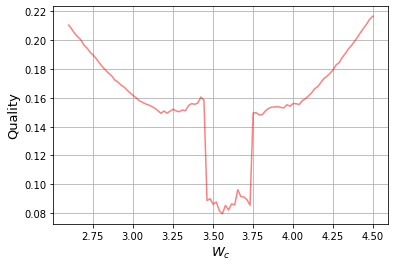

In [109]:
out = []
rs = np.linspace(min(rho),max(rho),100)
for r in tqdm(rs):
    out.append(goal_function([r,1.65,2.17,1.53], bounds=[(3.45,3.75),(1.,3.),(1.,3.),(0.,3.)]))
plt.plot(rs,out, c='r', alpha=.5)
plt.xlabel('$W_c$', fontsize=13)
plt.ylabel('Quality', fontsize=13)
plt.grid()
plt.show()


In [110]:
ret = autoscale(l, rho, a, da, 3.55,1.6,1.9, 1.4, bounds=[(3.4,3.75),(1.,3.),(1.,3.),(0.,3.)])
ret['errors'] = np.sqrt(np.diag(abs(ret['varco'])))
ret['rho'], ret['nu'], ret['zeta'], ret['alpha'] = ret['x']
ret['drho'], ret['dnu'], ret['dzeta'], ret['dalpha'] = ret['errors']
ret

<ipython-input-12-6304a316aa23>:140: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(varco)), varco


         alpha: 1.3217769474286567
        dalpha: 0.09813639337561801
           dnu: 0.1742261901924653
          drho: 0.0032445950942699307
         dzeta: 0.0897507129366936
        errors: array([0.0032446 , 0.17422619, 0.08975071, 0.09813639])
 final_simplex: (array([[3.89734918, 1.63972772, 1.79444341, 1.32177695],
       [3.89734921, 1.63979281, 1.79443073, 1.32177594],
       [3.89734917, 1.63981168, 1.79442776, 1.32177728],
       [3.89734914, 1.63969009, 1.79445106, 1.32177804],
       [3.89734914, 1.63971733, 1.79444579, 1.3217777 ]]), array([0.05143843, 0.05143844, 0.05143844, 0.05143845, 0.05143845]))
           fun: 0.051438434973531136
       message: 'Optimization terminated successfully.'
          nfev: 268
           nit: 136
            nu: 1.639727723185394
           rho: 3.8973491816239445
        status: 0
       success: True
         varco: array([[-1.05273973e-05, -1.32376804e-03,  3.97021673e-04,
         3.12394058e-04],
       [-1.32376804e-03,  3.035476

array([0.15674561, 0.50746081, 0.32512324, 1.14232727])

In [76]:
x, y, dy = scaledata(l, rho, a, da, ret['rho'], ret['nu'], ret['zeta'], ret['alpha'])

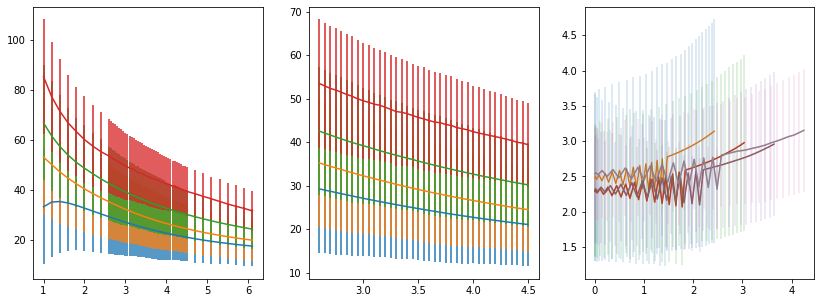

In [63]:
fig, ax = plt.subplots(1,3, figsize=(14,5))

for i,j,k in zip(np.vstack([rho_full,rho_full,rho_full,rho_full]),a_full,da_full):
    ax[0].errorbar(i,j, yerr=k)    

for i,j,k in zip(np.vstack([rho,rho,rho,rho]),a,da):
    ax[1].errorbar(i,j, yerr=k)    

for i,j,k in zip(x,y,dy):
    ax[2].errorbar(i,j, yerr=k, lw=.3)
    ax[2].plot(i,j)
#ax[1].set_xlim(0,100)